<a href="https://colab.research.google.com/github/slp22/deep-learning-project/blob/main/dl_diabetic_retinopathy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Deep Learning | Model

# Diabetic Retinopathy<a id='top'></a> 

## Imports

In [303]:
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import pandas as pd
import pathlib as Path
import pickle
import PIL
import random
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import warnings
import zipfile

from glob import glob
from IPython.display import SVG
from keras import backend as K
from keras import layers, models
from keras import regularizers, optimizers
from keras.applications import inception_v3, mobilenet_v2
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import InputLayer, Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import load_model, Sequential
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import model_to_dot

from PIL import Image

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

%pylab inline
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']  # or svg
pd.set_option('display.max_colwidth', None)
sns.set(context='notebook', style='whitegrid')
warnings.filterwarnings('ignore')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Matplotlib version:", matplotlib.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras Version:", tf.keras.__version__)
print("Scikit-learn version:", sk.__version__)


Populating the interactive namespace from numpy and matplotlib
Num GPUs Available:  1
Matplotlib version: 3.2.2
Numpy version: 1.21.6
Pandas version: 1.3.5
TensorFlow version: 2.8.2
Keras Version: 2.8.0
Scikit-learn version: 1.0.2


[Google Colabs](https://colab.research.google.com/notebooks/pro.ipynb#scrollTo=23TOba33L4qf): `If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to Runtime > Change runtime type in the menu to enable a GPU accelerator, and then re-execute the code cell.`

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

## 1 | Research Design


* **Research Question:** How well can a neural network diagnose diabetic retinopathy from a retinal image?
* **Impact Hypothesis:** *The client, the [National Eye Institute](https://www.nei.nih.gov/), part of the National Institutes of Health, wants a model that can quickly identify [diabetic retinopathy](https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy) in patients participating in early phase [clinical trials](https://iovs.arvojournals.org/article.aspx?articleid=2565675).*
* **Data source:** [Diabetic Retinopathy 2015 Data Colored Resized](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized) , n=35,126
* **Error metric:** Accruary for model iteratoins, precision and recall for final model

* **Data Dictionary:**
  * Classes = 5 stages of diabetic retinopathy:
    * **Normal eye**
    * **Mild** Nonproliferative Retinopathy: Microaneurysms are visbile, small areas of balloon-like swelling in the retina's tiny blood vessels.
    * **Moderate** Nonproliferative Retinopathy: Some blood vessels that nourish the retina are blocked.
    * **Severe** Nonproliferative Retinopathy: More blocked blood vessels, depriving several areas of the retina of blood supply; retina sends signals to the body to grow new blood vessels for nourishment.
    * **Proliferative** Retinopathy: Advanced stage; new blood vessels are abnormal and fragile; grow along the retina and along the surface of the clear, vitreous gel that fills the inside of the eye.


## 2 | Dataset: [Diabetic Retinopathy Retinal Images](https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized)

### Data Download

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sandralparedes","key":"746c1c655d0796973a3d3552fbcc97a5"}'}

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# assign to directory 
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [6]:
# download dataset from kaggle
! kaggle datasets download -d sovitrath/diabetic-retinopathy-2015-data-colored-resized

100% 1.93G/1.94G [00:16<00:00, 129MB/s]
100% 1.94G/1.94G [00:16<00:00, 126MB/s]


In [7]:
# unzip kaggle file
zip_ref = zipfile.ZipFile('diabetic-retinopathy-2015-data-colored-resized.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

## 3 | Exploratory Data Analysis

### Data Size and Classes

In [8]:
# show number of classes and images
source_images_path = '/tmp/colored_images/colored_images/'
extracted_directories_path = os.listdir(source_images_path)

for image_directory in extracted_directories_path:
  print(image_directory, len(os.listdir(os.path.join(source_images_path, image_directory))))

Severe 873
Mild 2443
No_DR 25810
Moderate 5292
Proliferate_DR 708


In [9]:
filepath = '/tmp/colored_images/colored_images'
dataframe = {'image_path':[],'diagnosis':[]}

for diagnosis in os.listdir(filepath):
    print(diagnosis)
    if diagnosis != 'colored_images':        
        for image in os.listdir(filepath +"/"+diagnosis):
            if image != 'Dataset':
                dataframe['image_path'].append(filepath +"/"+diagnosis+"/"+ image)
                dataframe['diagnosis'].append(diagnosis)
dataframe = pd.DataFrame(dataframe)  
dataframe.info()
dataframe.head(2)

Severe
Mild
No_DR
Moderate
Proliferate_DR
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  35126 non-null  object
 1   diagnosis   35126 non-null  object
dtypes: object(2)
memory usage: 549.0+ KB


,image_path,diagnosis
0,/tmp/colored_images/colored_images/Severe/10125_right.png,Severe
1,/tmp/colored_images/colored_images/Severe/20613_left.png,Severe


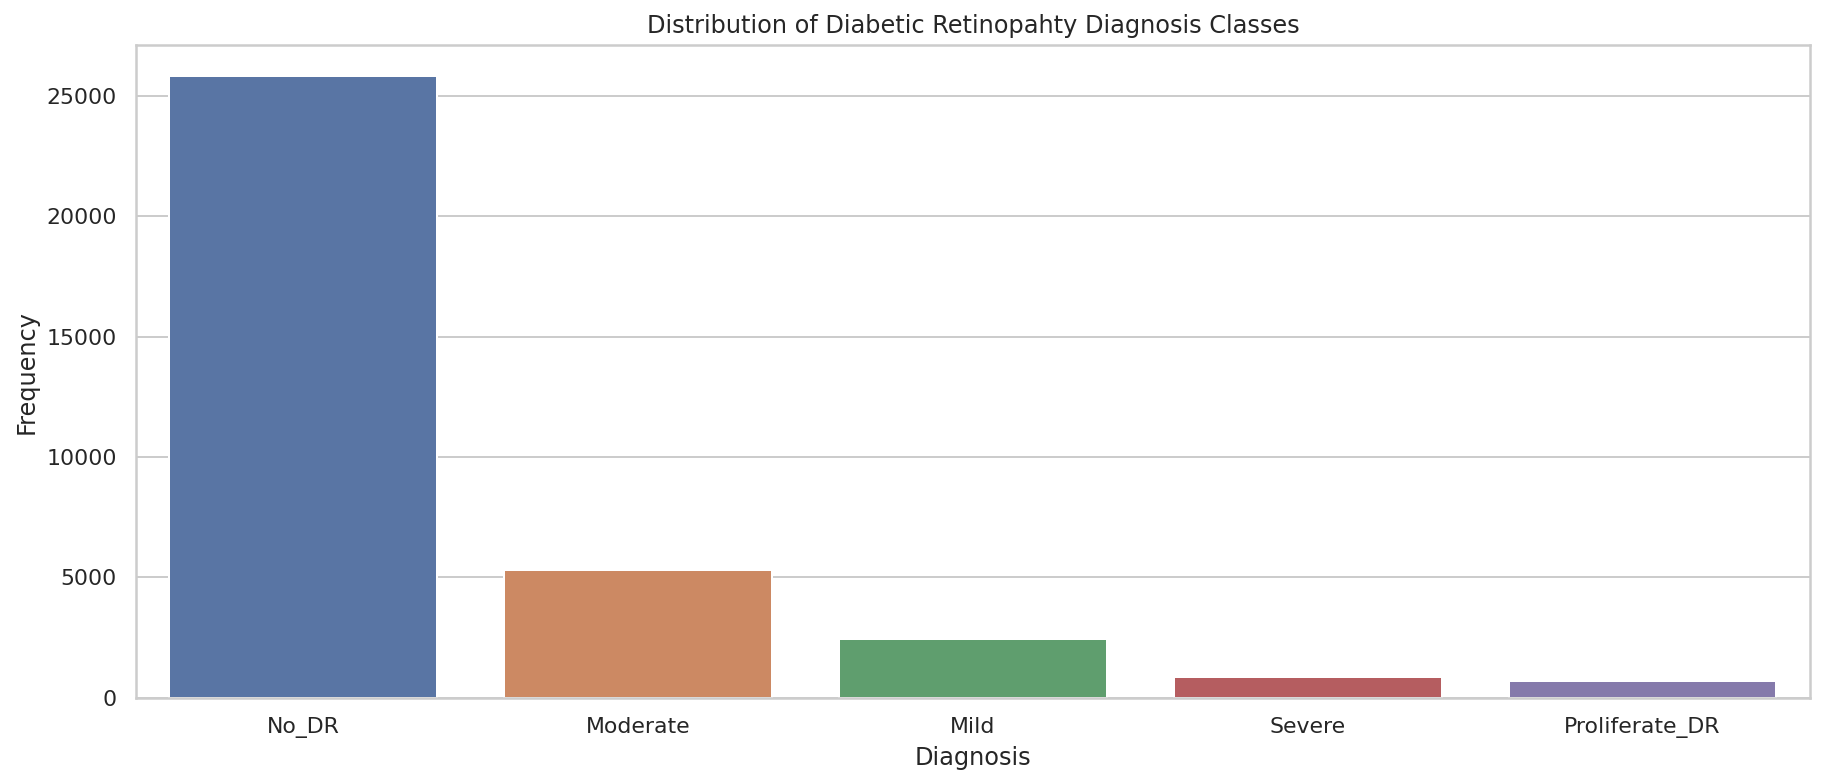

In [10]:
# distribution of five diagnosis classes in order of severity of disease

plt.figure(figsize=(15,6))
sns.barplot(dataframe.diagnosis.value_counts().index,
            dataframe.diagnosis.value_counts(),
            palette=None)
plt.title("Distribution of Diabetic Retinopahty Diagnosis Classes")
plt.xlabel("Diagnosis")
plt.ylabel("Frequency");


### Preview Images

No Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


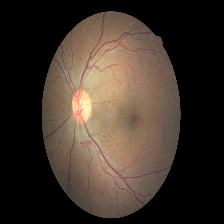

In [11]:
# view one healthy eye image

path = '/tmp/colored_images/colored_images/No_DR/10003_left.png'

healthy_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256),
   interpolation="nearest")

print('No Diabetic Retinopthy')
print('Datatype:', type(healthy_image))
healthy_image 


Proliferate Diabetic Retinopthy
Datatype: <class 'PIL.PngImagePlugin.PngImageFile'>


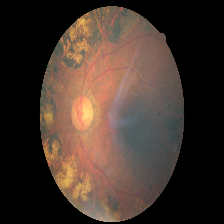

In [12]:
# view one proliferate DR image (most advanced stage of disease)

path = '/tmp/colored_images/colored_images/Proliferate_DR/10017_left.png'

proliferate_image = tf.keras.preprocessing.image.load_img(
   path,
   grayscale=False, 
   color_mode="rgb", 
  #  target_size=(256, 256), 
   interpolation="nearest")

print('Proliferate Diabetic Retinopthy')
print('Datatype:', type(proliferate_image))
proliferate_image 


### **Data Summary: n = 35,126;  unbalanced classes**

## 4 | Validation

### Test/Train

In [13]:
# make train/test folders

temp_path = '/tmp'
raw_data_dir_name = 'raw_data'

train_data_dir_name = 'train'
test_data_dir_name = 'test'
raw_data_directories = [train_data_dir_name, test_data_dir_name]

images_path =  os.path.join(temp_path, raw_data_dir_name)
tmp_directories = os.listdir(temp_path)

def build_raw_data_directory(parent, directory):
  dir_path = os.path.join(parent, directory)
  os.mkdir(dir_path)
  for dir in extracted_directories_path:
    os.mkdir(os.path.join(dir_path, dir))

if raw_data_dir_name not in tmp_directories:
  os.mkdir(images_path)
  for directory in raw_data_directories:
    build_raw_data_directory(images_path, directory)
else:
  print(raw_data_dir_name, " already exist")
  images_path_directories = os.listdir(images_path)
  for directory in raw_data_directories:
    if directory not in images_path_directories:
      build_raw_data_directory(images_path, directory)

In [14]:
## In case folder creation fails: 
### shutil.rmtree('/tmp/raw_data/train/')
### shutil.rmtree('/tmp/raw_data/test/')
### shutil.rmtree('/tmp/raw_data/')


In [15]:
## split data into train/test folders

distribution = 0.2

raw_data_path = os.path.join(temp_path, raw_data_dir_name)
test_data_path_root = os.path.join(raw_data_path, test_data_dir_name)
train_data_path_root = os.path.join(raw_data_path, train_data_dir_name)

data_dirs = os.listdir(source_images_path)

for dir in data_dirs:
  path = os.path.join(source_images_path, dir)
  test_data_path = os.path.join(test_data_path_root, dir)
  train_data_path = os.path.join(train_data_path_root, dir)
  images = os.listdir(path)
  print(path, test_data_path)
  for image in images:
    random_number = random.uniform(0, 1)
    is_test_image = random_number < distribution
    source_image_path = os.path.join(path, image)
    # shutil.copy(src, dst)
    if is_test_image:
      shutil.copy(source_image_path, test_data_path)
      # print(source_image_path, "goes to test", test_data_path)
    else:
      shutil.copy(source_image_path, train_data_path)
      # print(source_image_path, "goes to train", train_data_path)

test_data_path_root = os.path.join(raw_data_path, test_data_dir_name)
train_data_path_root = os.path.join(raw_data_path, train_data_dir_name)

test_dirs = os.listdir(test_data_path_root)
train_dirs = os.listdir(train_data_path_root)

for dir in test_dirs:
  path = os.path.join(test_data_path_root, dir)
  files = os.listdir(path)
  print(path, len(files))

for dir in train_dirs:
  path = os.path.join(train_data_path_root, dir)
  files = os.listdir(path)
  print(path, len(files))

/tmp/colored_images/colored_images/Severe /tmp/raw_data/test/Severe
/tmp/colored_images/colored_images/Mild /tmp/raw_data/test/Mild
/tmp/colored_images/colored_images/No_DR /tmp/raw_data/test/No_DR
/tmp/colored_images/colored_images/Moderate /tmp/raw_data/test/Moderate
/tmp/colored_images/colored_images/Proliferate_DR /tmp/raw_data/test/Proliferate_DR
/tmp/raw_data/test/Severe 178
/tmp/raw_data/test/Mild 507
/tmp/raw_data/test/No_DR 5112
/tmp/raw_data/test/Moderate 1084
/tmp/raw_data/test/Proliferate_DR 148
/tmp/raw_data/train/Severe 695
/tmp/raw_data/train/Mild 1936
/tmp/raw_data/train/No_DR 20698
/tmp/raw_data/train/Moderate 4208
/tmp/raw_data/train/Proliferate_DR 560


### **Train (80%) and test (20%) folders**

## 5 | Non-Deep Learning Model: Logistic Regression

### Image Data Setup
Code adapted from [sdblass](https://github.com/sdblass/Metis_coursework/blob/master/6_Deep_Learning/2_baseline_model.ipynb)

In [91]:
# create raw_data_small set to use in logistic regression model
original_raw_data_path = '/tmp/raw_data'
raw_data_copy = '/tmp/raw_data_small'
# shutil.copytree(original_raw_data_path, raw_data_copy)

raw_data_copy_test_path = '/tmp/raw_data_small/test'
raw_data_copy_train_path = '/tmp/raw_data_small/train'

# # cull to keep 200 images from each class in raw_data_small
paths_to_reduce_images = [raw_data_copy_test_path, raw_data_copy_train_path]

for path in paths_to_reduce_images:
  dir_names = os.listdir(path)
  for dir_name in dir_names:
    images_path = os.path.join(path, dir_name)
    files = os.listdir(images_path)
    for index, file in enumerate(files):
      if index >= 200:
        file_path = os.path.join(images_path, file)
        os.remove(file_path)

In [92]:
root = '/tmp/raw_data_small/train'
retinas = os.listdir(root)
retinas = [retina for retina in retinas if retina[0]!='.']

In [93]:
# convert image to 1D vector
test_img_path = os.listdir(root+f'/{retinas[0]}')[0]
test_img_path = root+f'/{retinas[0]}' + f'/{test_img_path}'
test_img = Image.open(test_img_path)

In [94]:
# num pixels
dimension = np.array(test_img).reshape(-1).shape[0]
dimension

150528

In [95]:
# function to count images
def image_count(num_diagnoses, root): 
  num_images = 0
  for i, retina in enumerate(retinas):
    if i == num_diagnoses: break
    num_images += len(os.listdir(root + f'/{retina}'))
  return num_images

In [96]:
# num images in raw_data_small; 5 classes (diagnoses) 
image_count(5, root) 

1000

In [28]:
# # initialize 2D matrix with dimensions equal to num of images times num of pixels
# image_repo = np.zeros([image_count(5, root), dimension])
# image_repo

In [97]:
# function to vectorize images in raw_data_small/train
def img_vectorization(num_diagnoses, root):
  image_repo = np.zeros([image_count(num_diagnoses, root), dimension])
  count = 0
  diagnosis = []
  for i, retina in enumerate(retinas):
    images = os.listdir(root + f'/{retina}')
    for image in images:
      img = Image.open(root + f'/{retina}' + f'/{image}')
      row = np.array(img).reshape(-1)
      image_repo[count, :] = row
      diagnosis.append(retina)
      img.close()
      count += 1
    if i == num_diagnoses - 1: 
      return image_repo, diagnosis
  return image_repo, diagnosis
# print(image_repo.shape)

In [98]:
X_train, y_train_dx = img_vectorization(5, root)

In [99]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [100]:
print('X train shape:', X_train.shape)
print('y train (dx) length:', len(y_train_dx))

X train shape: (1000, 150528)
y train (dx) length: 1000


In [101]:
# vectorize raw_data_small/test data
root_test = '/tmp/raw_data_small/test'
X_test, y_test_dx = img_vectorization(5, root_test)

In [102]:
print(X_test)
print(X_test.shape)
print(len(y_test_dx))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(926, 150528)
926


In [103]:
# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

type(X_train)

numpy.ndarray

### PCA

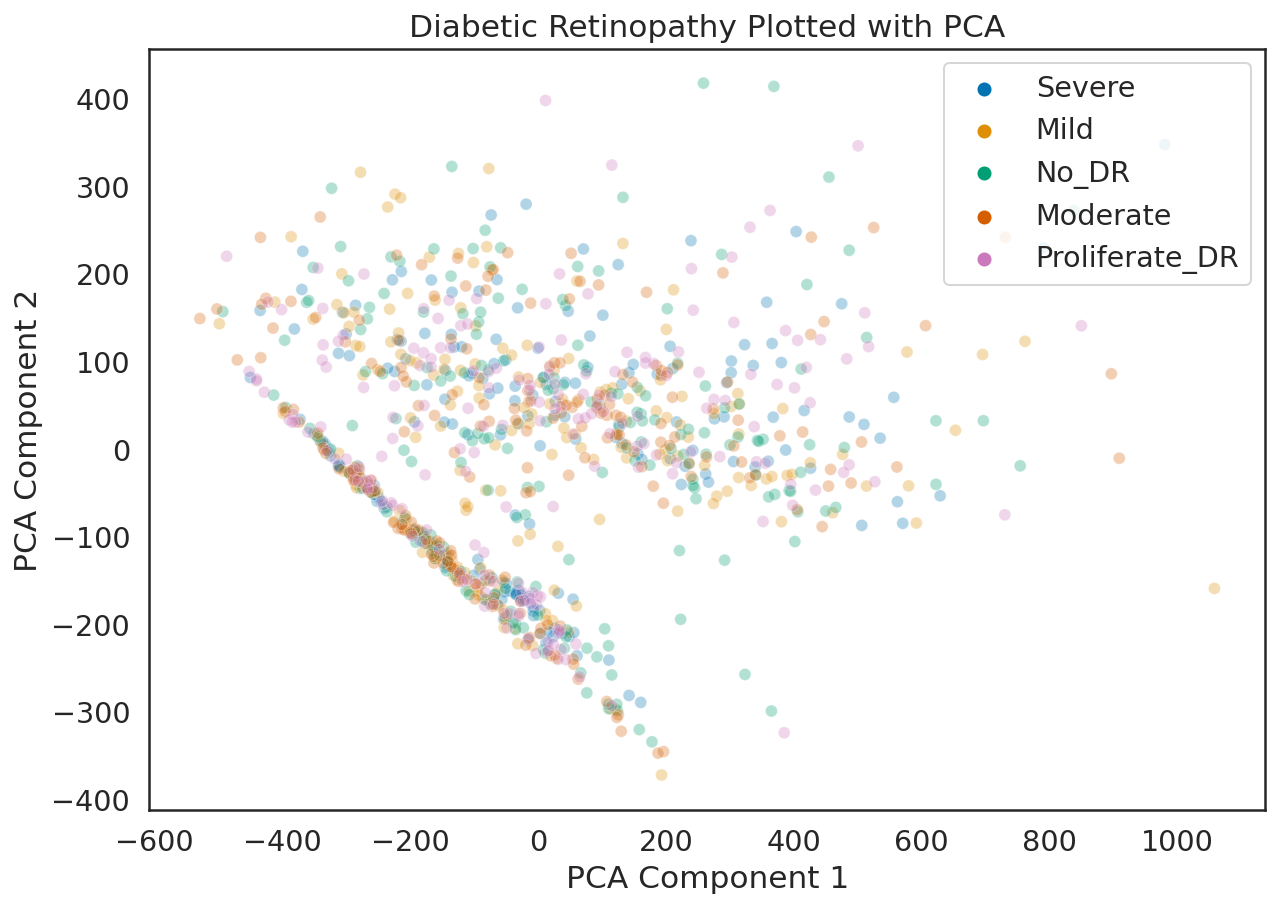

In [104]:
# PCA 2 components
pca = PCA(n_components=2)
X_train_2PC = np.asarray(pca.fit_transform(X_train))
X_test_2PC = np.asarray(pca.transform(X_test))

sns.scatterplot(x=X_train_2PC[:, 0], 
                y=X_train_2PC[:, 1],
                hue=y_train_dx, 
                alpha=.3,
                palette=sns.color_palette("colorblind", 5))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc='upper right')
plt.title("Diabetic Retinopathy Plotted with PCA")
plt.savefig('PCA.png');


In [105]:
# logistic regression baseline with PCA
baseline_lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
baseline_lr.fit(X_train_2PC, y_train_dx)

score = baseline_lr.score(X_test_2PC, y_test_dx)
print('Logistic Regresion PCA Baseline Score = ', score)

Logistic Regresion PCA Baseline Score =  0.23110151187904968


### Truncated SVD


In [106]:
# truncated SVD
svd = TruncatedSVD(n_components=2)
X_train_2d = svd.fit_transform(X_train)
X_test_2d = svd.transform(X_test)

print('X_train_2d', X_train_2d.shape)
print('X_test_2d', X_test_2d.shape)

X_train_2d (1000, 2)
X_test_2d (926, 2)


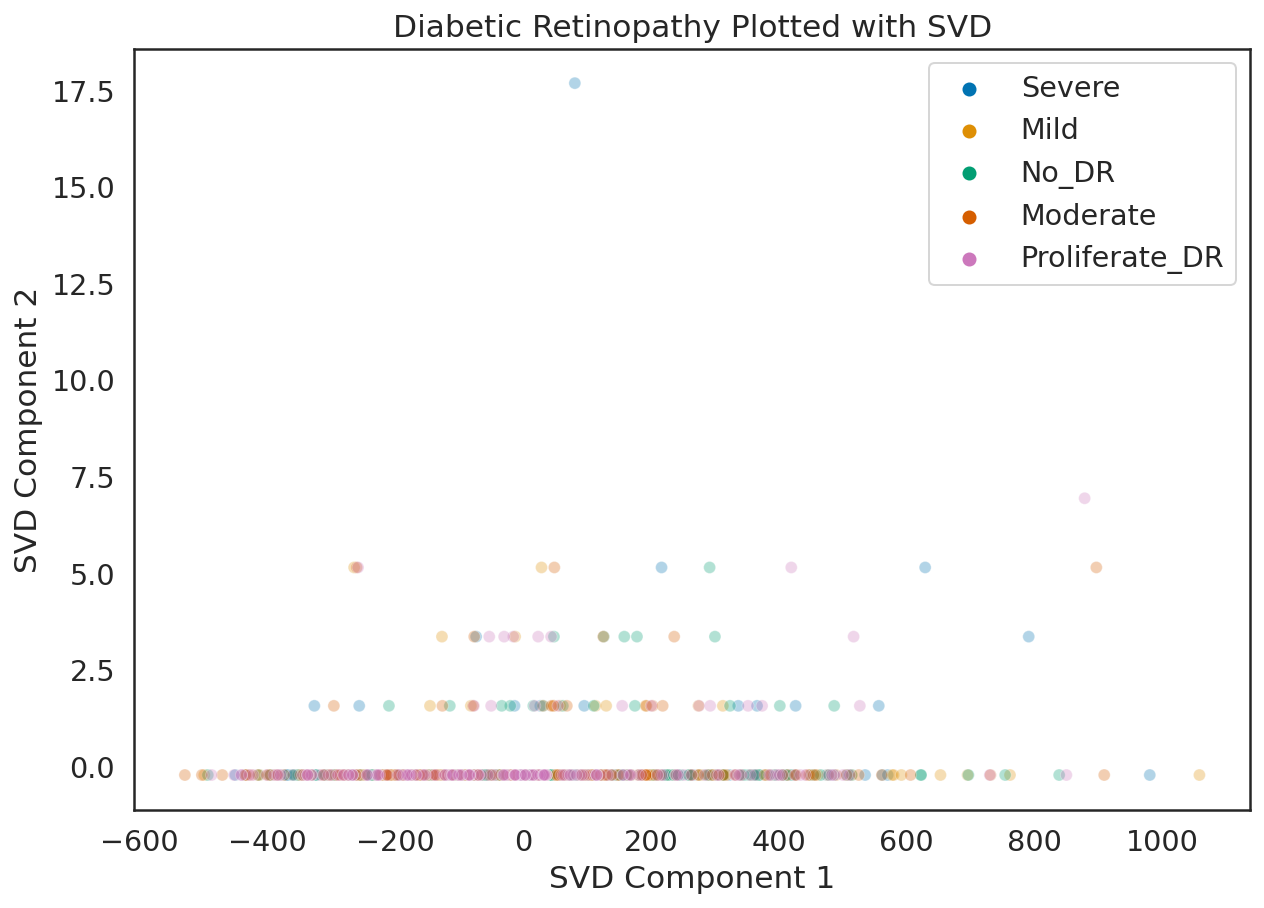

In [107]:
#plot TruncatedSVD
sns.set(style='white', rc={"figure.figsize":(10, 7)}, font_scale=1.3)
sns.scatterplot(x=X_train_2d[:, 0], 
                y=X_train[:, 1],
                hue=y_train_dx, 
                alpha=.3,
                palette=sns.color_palette("colorblind", 5))
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.legend(loc='upper right')
plt.title("Diabetic Retinopathy Plotted with SVD");
plt.savefig('TruncatedSVD.png');

In [108]:
# logistic regression baseline with SVD
baseline_lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
baseline_lr.fit(X_train_2d, y_train_dx)

score = baseline_lr.score(X_test_2d, y_test_dx)
print('Logistic Regresion SVD Baseline Score = ', score)

Logistic Regresion SVD Baseline Score =  0.23110151187904968



### Logistic regression accuracy scores for classifying diabetic retinopathy based on retinal images
* PCA score =  0.20350109409190373
* SVD score =  0.20350109409190373

## 6 | Deep Learning Models

### ImageDataGenerator


Code adapted from [stackoverflow](https://stackoverflow.com/questions/61215270/input-shape-with-image-generator-in-tensorflow) and [medium](https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720) and [github/kasteway](https://github.com/kasteway/Road-_Sign_Classification/blob/main/CNN%20updated%20Initial%20Model.ipynb)

In [109]:
K.set_image_data_format('channels_last')
# any model loaded from Keras Apps will get built according to the TensorFlow data format convention, "Height-Width-Depth".
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

train_dir  = '/tmp/raw_data/train'
test_dir = '/tmp/raw_data/test'

img_width, img_height = 32, 32
input_shape = img_width, img_height, 3

num_train_samples = 32000
num_test_samples = 320



train_datagen = ImageDataGenerator(
    rescale = 1. /255)

test_datagen = ImageDataGenerator(
    rescale = 1. /255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    color_mode = 'rgb',
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False,
    seed=42)  

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = 32,
    class_mode = 'categorical',
    seed=42)  


Found 28097 images belonging to 5 classes.
Found 7029 images belonging to 5 classes.


In [110]:
print(input_shape)

(32, 32, 3)


In [111]:
# https://expoundai.wordpress.com/2019/04/24/image-data-generators-in-keras/

print('num samples', train_data.samples)
print('num classes', len(train_data.class_indices))
print('num samples per class', int(train_data.samples/len(train_data.class_indices)))

num samples 28097
num classes 5
num samples per class 5619


In [112]:
print(train_data.class_indices)

{'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}


In [113]:
train_data.filenames[0:5]

['Mild/10030_left.png',
 'Mild/10030_right.png',
 'Mild/10085_left.png',
 'Mild/10085_right.png',
 'Mild/10169_right.png']

In [114]:
X_train, y_train = next(train_data)
print('X_train type', type(X_train))
print('y_train type', type(y_train))
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)

X_train type <class 'numpy.ndarray'>
y_train type <class 'numpy.ndarray'>
X_train shape (32, 32, 32, 3)
y_train shape (32, 5)


In [306]:
X_test, y_test = next(test_data)
print('X_train type', type(X_test))
print('y_train type', type(y_test))
print('X_train shape', X_test.shape)
print('y_train shape', y_test.shape)

X_train type <class 'numpy.ndarray'>
y_train type <class 'numpy.ndarray'>
X_train shape (32, 32, 32, 3)
y_train shape (32, 5)


### 6.1 Neural Network

In [115]:
NN_model = Sequential()

NN_model.add(InputLayer(input_shape=input_shape))
NN_model.add(Flatten())
NN_model.add(Dense(units=10, activation="relu"))
NN_model.add(Dense(units=5, activation='softmax'))

NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_7 (Dense)             (None, 10)                30730     
                                                                 
 dense_8 (Dense)             (None, 5)                 55        
                                                                 
Total params: 30,785
Trainable params: 30,785
Non-trainable params: 0
_________________________________________________________________


In [116]:
NN_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
    )

In [117]:
# STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
# STEP_SIZE_TEST = test_data.n//test_data.batch_size

history = NN_model.fit_generator(
    generator=train_data,
    steps_per_epoch=32,
    validation_data=test_data,
    validation_steps=32, 
    epochs= 5, 
    verbose=2
    )

Epoch 1/5
32/32 - 3s - loss: 1.0409 - accuracy: 0.7070 - val_loss: 1.0214 - val_accuracy: 0.7109 - 3s/epoch - 100ms/step
Epoch 2/5
32/32 - 3s - loss: 0.9508 - accuracy: 0.7197 - val_loss: 0.9396 - val_accuracy: 0.7266 - 3s/epoch - 85ms/step
Epoch 3/5
32/32 - 3s - loss: 0.8915 - accuracy: 0.7549 - val_loss: 0.9144 - val_accuracy: 0.7266 - 3s/epoch - 87ms/step
Epoch 4/5
32/32 - 3s - loss: 0.8802 - accuracy: 0.7510 - val_loss: 0.9152 - val_accuracy: 0.7256 - 3s/epoch - 89ms/step
Epoch 5/5
32/32 - 3s - loss: 0.9178 - accuracy: 0.7334 - val_loss: 0.8630 - val_accuracy: 0.7451 - 3s/epoch - 86ms/step


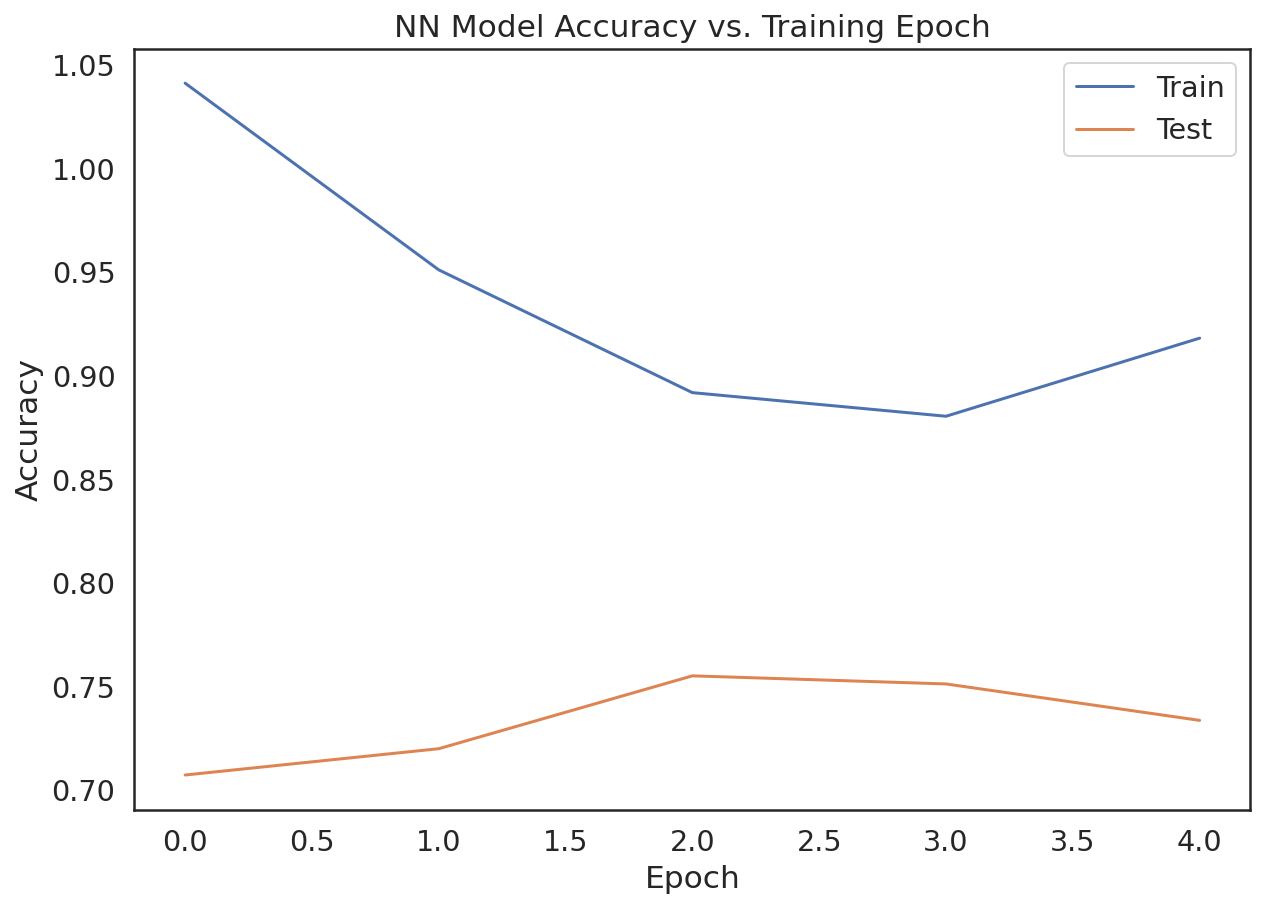

In [118]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.title('NN Model Accuracy vs. Training Epoch')
plt.savefig('NN_Accuracy_vs_Training_Epoch.png');

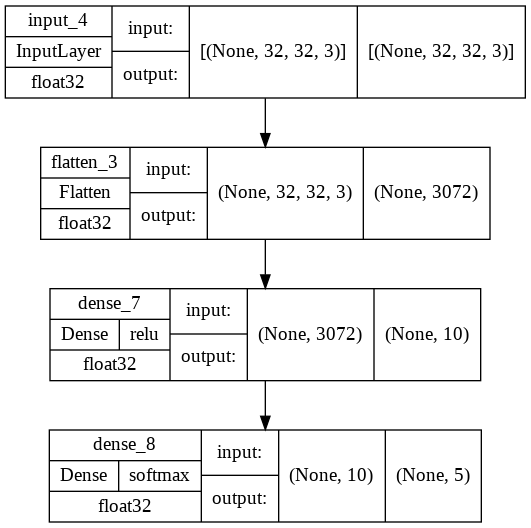

In [119]:
# show model 
tf.keras.utils.plot_model(
    NN_model,
    to_file="NN_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [ ]:
# save NN_model 
NN_model.save_weights('NN_model_saved.h5')



## NN accuracy scores for classifying diabetic retinopathy based on retinal images
* accuracy = **0.###**
* val_accuracy = **0.###**


### 6.2 Convolutional Neural Network

In [120]:
print(input_shape)

(32, 32, 3)


In [121]:
CNN_model = Sequential()

CNN_model.add(InputLayer(input_shape=(input_shape)))
CNN_model.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
CNN_model.add(MaxPooling2D())

CNN_model.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
CNN_model.add(MaxPooling2D())

CNN_model.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
CNN_model.add(MaxPooling2D())

CNN_model.add(Flatten())
CNN_model.add(Dense(1028, activation='softmax')) 
CNN_model.add(Dense(5, activation='softmax')) 

In [122]:
CNN_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
    )

In [123]:
# STEP_SIZE_TRAIN = train_data.n//train_data.batch_size
# STEP_SIZE_TEST = test_data.n//test_data.batch_size

history = CNN_model.fit_generator(
    generator=train_data,
    steps_per_epoch=32,
    validation_data=test_data,
    validation_steps=32, 
    epochs= 5,
    verbose=2
    )

Epoch 1/5
32/32 - 3s - loss: 1.5476 - accuracy: 0.7275 - val_loss: 1.4860 - val_accuracy: 0.7207 - 3s/epoch - 105ms/step
Epoch 2/5
32/32 - 3s - loss: 1.4490 - accuracy: 0.7241 - val_loss: 1.4132 - val_accuracy: 0.7344 - 3s/epoch - 86ms/step
Epoch 3/5
32/32 - 3s - loss: 1.3745 - accuracy: 0.7393 - val_loss: 1.3489 - val_accuracy: 0.7236 - 3s/epoch - 87ms/step
Epoch 4/5
32/32 - 3s - loss: 1.3126 - accuracy: 0.7461 - val_loss: 1.2859 - val_accuracy: 0.7412 - 3s/epoch - 85ms/step
Epoch 5/5
32/32 - 3s - loss: 1.2631 - accuracy: 0.7402 - val_loss: 1.2412 - val_accuracy: 0.7373 - 3s/epoch - 86ms/step


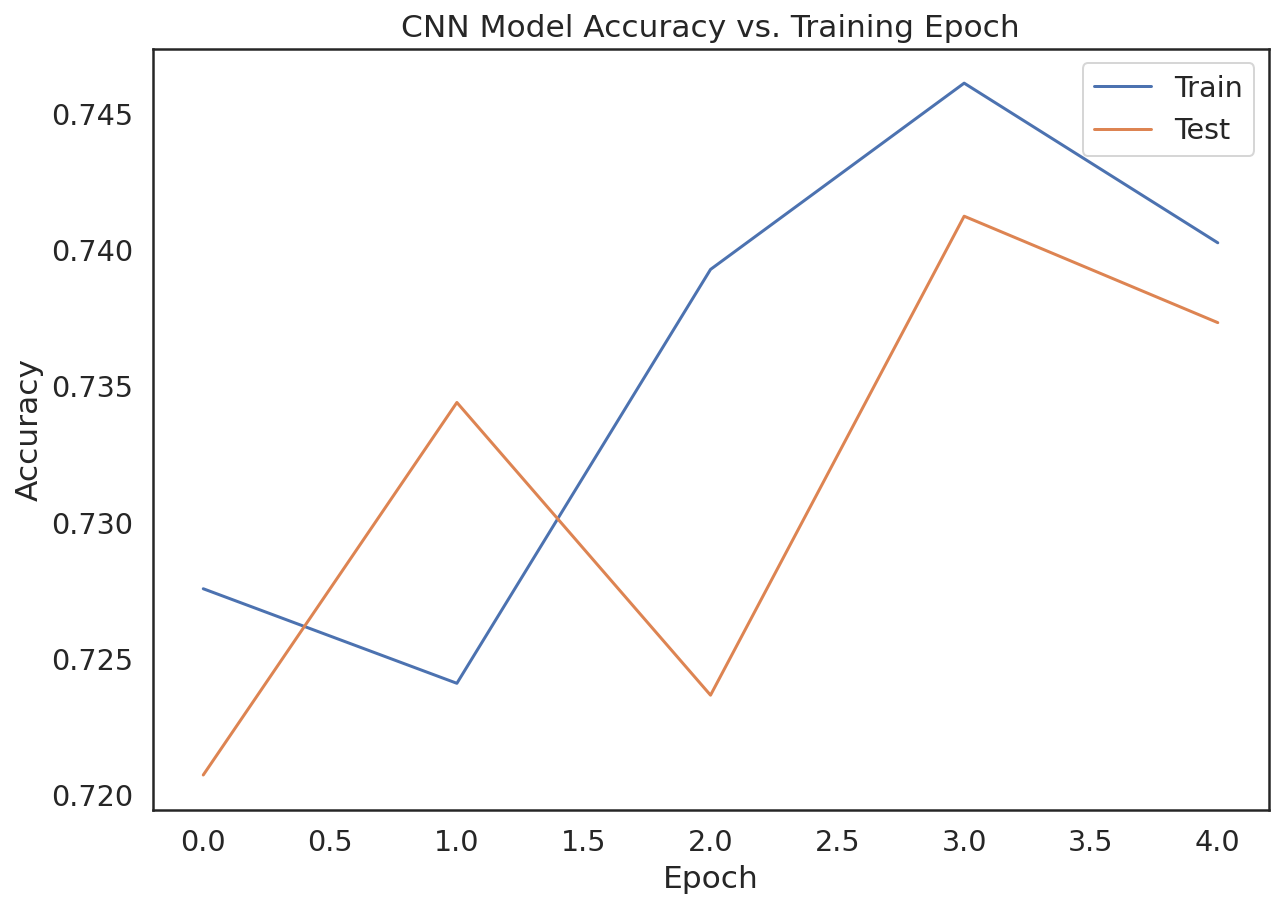

In [124]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.title('CNN Model Accuracy vs. Training Epoch')
plt.savefig('CNN_Accuracy_vs_Training_Epoch.png');

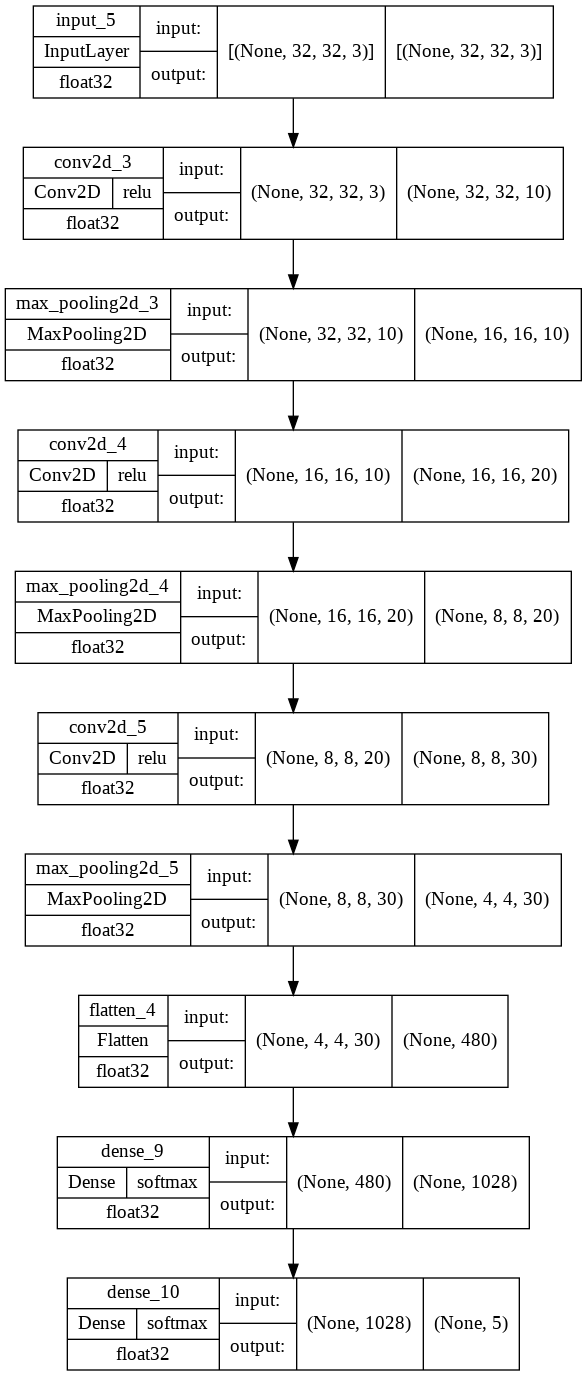

In [125]:
# show model 

tf.keras.utils.plot_model(
    CNN_model,
    to_file="CNN_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [133]:
# save CNN_model 
CNN_model.save_weights('CNN_model_saved.h5')


### CNN accuracy scores for classifying diabetic retinopathy based on retinal images
* accuracy = **0.###**
* val_accuracy = **0.###**


### 6.3 VGG16

Code adpated from [TowardsDataScience](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4)

In [ ]:
vgg_model = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
    )
vgg_model.trainable = False
vgg_model.summary() 

In [60]:
# ###Need to preprocess_input?
# train_vgg = preprocess_input(train_data)
# test_vgg = preprocess_input(test_data)


ValueError: Input 0 of layer "sequential_10" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(32, 5)

In [323]:
VGG16_model = Sequential()

VGG16_model.add(InputLayer(input_shape=(input_shape)))
VGG16_model.add(Flatten())
VGG16_model.add(Dense(500, activation='relu'))
VGG16_model.add(Dense(200, activation='relu'))
# VGG16_model.add(Dense(1028, activation='softmax')) 
VGG16_model.add(Dense(5, activation='softmax'))

In [324]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.002,
    name="Adam")

VGG16_model.compile(
    optimizer = optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )
es = [
    EarlyStopping(
        monitor='val_accuracy', 
        mode='max',
        patience=5,
        verbose=1,
        restore_best_weights=True),
    ReduceLROnPlateau(
        factor=.5, 
        patience=3, 
        verbose=1)
    ] 

In [325]:
# num_train_samples = 32000
# num_test_samples = 320
batch_size = 32
epochs = 5

history = VGG16_model.fit_generator(
    generator=train_data,
    steps_per_epoch= num_train_samples // batch_size,
    epochs=epochs
    validation_data=test_data,
    validation_steps= num_test_samples // batch_size,
    callbacks=[es],
    verbose=2
    )     
          

32/32 - 3s - loss: 1.5517 - accuracy: 0.6699 - val_loss: 1.2090 - val_accuracy: 0.3887 - lr: 0.0020 - 3s/epoch - 101ms/step


* accuracy = 0.7324
* val_accuracy = 0.9312

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])

# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['Train', 'Test'])
# plt.title('VGG16 Model Model Accuracy vs. Training Epoch')
# plt.savefig('VGG16_Accuracy_vs_Training_Epoch.png');

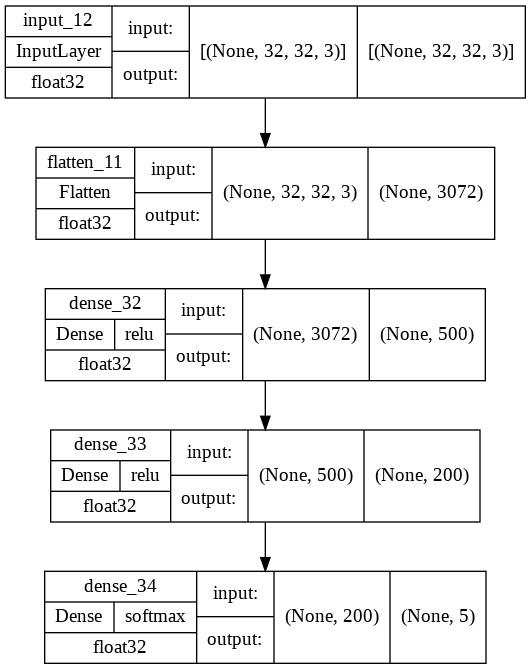

In [326]:
# show VGG16_model 

tf.keras.utils.plot_model(
    VGG16_model,
    to_file="VGG16_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)



In [327]:
VGG16_model.save_weights('VGG16_model_saved.h5')

!mkdir -p saved_model
VGG16_model.save('saved_model/VGG16_model_saved') 


INFO:tensorflow:Assets written to: saved_model/VGG16_model_saved/assets


INFO:tensorflow:Assets written to: saved_model/VGG16_model_saved/assets


### VGG16 model accuracy scores for classifying diabetic retinopathy based on retinal images
* accuracy = **0.###**
* val_accuracy = **0.###**

## 7 | Model: Diagnosing Diabetic Retinopathy

### attempt 1

In [ ]:
# https://stackoverflow.com/questions/45806669/how-to-use-predict-generator-with-imagedatagenerator

# STEP_SIZE_TEST = test_data.n//test_data.batch_size

test_data.reset()

y_predict = VGG16_model.predict_generator(
    test_data,
    steps=32,
    verbose=1)

# y_predict = np.argmax(VGG16_model.predict_generator(test_data),axis =1)


In [ ]:
predicted_class_indices = np.argmax(y_predict,axis=1)
predicted_class_indices

In [332]:
labels = (predicted_class_indices)
labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]

print(len(predictions)) #7008
print(type(predictions))

7008
<class 'list'>


In [334]:
print(type(pred)) #numpy array, len=7029
print(len(pred))
predict = pred[:7008]
len(pred)

7008

In [335]:
filenames = test_data.filenames
filenames = filenames[:7008]

results = pd.DataFrame({"Filename": filenames, "Predictions": predictions})
results.to_csv("results.csv",index=False)

In [359]:
results.columns

Index(['Filename', 'Predictions'], dtype='object')

In [ ]:
y_actual = results['Filename']
y_actual

In [ ]:
y_pred = results['Predictions']
y_pred

In [ ]:
cm = confusion_matrix(y_actual, y_pred)
cm

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Reds')

ax.xaxis.set_ticklabels(['true','false'])
ax.yaxis.set_ticklabels(['true','false'])

plt.title('Confusion Matrix' '\n' 'threshold = 0.05 (X_test, y_test)')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual ')

plt.savefig("confusion-matrix.jpeg");

In [285]:
# https://www.tensorflow.org/tutorials/images/classification

class_names = ['No_DR','Mild','Moderate','Severe', 'Proliferate_DR']
# train_data.class_indices

img_path = '/tmp/raw_data/test/Mild/10150_right.png'

img = tf.keras.utils.load_img(
    img_path, target_size=(32, 32))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = VGG16_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to Moderate with a 40.46 percent confidence.


### attempt 2

In [ ]:
# https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

# num_test_samples = 320
batch_size = 32

#Confusion Matrix and Classification Report
Y_pred = VGG16_model.predict_generator(test_data, num_test_samples // batch_size +1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix'
print(confusion_matrix(test_data.classes, y_pred))

print('Classification Report')
target_names = ['Severe', 'Mild','No_DR','Moderate','Proliferate_DR']
print(classification_report(test_data.classes, y_pred, target_names=target_names))

In [ ]:
# predict(
#     x,
#     batch_size=None,
#     verbose='auto',
#     steps=None,
#     callbacks=None,
#     max_queue_size=10,
#     workers=1,
#     use_multiprocessing=False
# )

# # A generator or keras.utils.Sequence instance. A more detailed description of 
# # unpacking behavior for iterator types (Dataset, generator, Sequence) is given in the Unpacking behavior for iterator-like inputs section of Model.fit.
# # Do not specify the batch_size if your data is in the form of dataset, generators

# # workers	Integer. Used for generator or keras.utils.Sequence input only. 
# # Maximum number of processes to spin up when using process-based threading. 
# # If unspecified, workers will default to 1.

https://stackoverflow.com/questions/45806669/how-to-use-predict-generator-with-imagedatagenerator

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

for computing accuracy, instead of computing it manually, you could use model.evaluate(test_data, target_data) or using generator model.evaluate(test_generator, ...). but do not f

In [ ]:
desired_batch_size=7

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(200, 200),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=desired_batch_size)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = 
                                   np.ceil(nb_samples/desired_batch_size))

https://www.tensorflow.org/tutorials/quickstart/beginner

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)


In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(x_test[:5])


https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [ ]:
# Generates random parameters for a transformation.

get_random_transform(
    img_shape, seed=None
)

In [ ]:
# Applies a random transformation to an image.
random_transform(
    x, seed=None
)


In [ ]:
fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

In [ ]:
# Function. The function created by this method should 
# accept a tf.data.Iterator, and return the outputs of the Model.


make_predict_function(
    force=False
)

In [ ]:
evaluate(
    x=None,
    y=None,
    batch_size=None,
    verbose='auto',
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
    **kwargs
)